In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from rdp import rdp as rdp_classic
import time
import traj_dist.distance as tdist
import traj_dist.pydist.sspd as sspd

from traj_toolbox.cy_tools import rdp_recursive as cy_rdp
from multiprocessing import Pool

import fastcluster as fc
import scipy.cluster.hierarchy as sch

# Config

In [2]:
IF = -50e6
t = np.arange(0, 8e-6, 2e-9)[500:2000]

OUTPUT_PATH = 'result_data/'
eps = 2.

# Data Load

In [3]:
with open("raw_data/calibration_curves_1000_(2022-03-10).pkl", "rb") as f:
    data = pickle.load(f)
data = list(data.values())

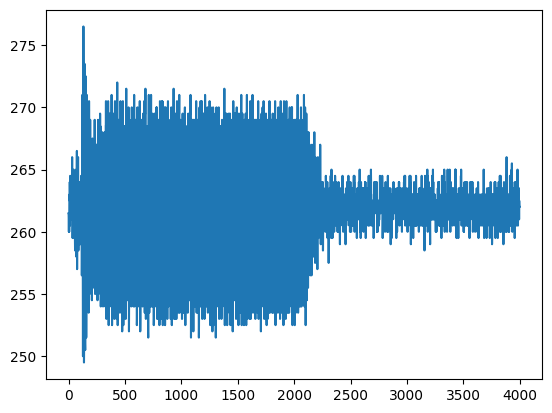

In [4]:
plt.plot(data[1][0][0])

In [5]:
def exponential_rotation(I, Q, IF, t, direction):
    if direction == 'clockwise':
        output = (I+1j*Q)*np.exp(-1j*2*np.pi*IF*t)
    else:
        output = (I+1j*Q)*np.exp(1j*2*np.pi*IF*t)
    return output.real, output.imag

In [6]:
E = []
G = []

for i in range(len(data)):
    Ig = data[i][0][0][500:2000]
    Qg = data[i][1][0][500:2000]
    Ie = data[i][2][0][500:2000]
    Qe = data[i][3][0][500:2000]

    Ig -= Ig.mean()
    Qg -= Qg.mean()
    Ie -= Ie.mean()
    Qe -= Qe.mean()

    Ig_rotate, Qg_rotate = exponential_rotation(Ig, Qg, IF, t, "1")
    Ie_rotate, Qe_rotate = exponential_rotation(Ie, Qe, IF, t, "1")

    G_stack = np.column_stack([Ig_rotate, Qg_rotate])
    E_stack = np.column_stack([Ie_rotate, Qe_rotate])

    G.append(G_stack)
    E.append(E_stack)


# reducing the dimensionality via Ramer_Douglas_Peucker

In [32]:
%%time
"OLD WAY"
G_reduce_size = [rdp(G[i], epsilon=eps) for i in range(len(G))]
E_reduce_size = [rdp(E[i], epsilon=eps) for i in range(len(E))]

CPU times: user 12min 51s, sys: 25.9 ms, total: 12min 51s
Wall time: 12min 51s


In [7]:
%%time
"NEW WAY"
G_reduce_size = [cy_rdp.RDP(G[i], epsilon=eps) for i in range(len(G))]
E_reduce_size = [cy_rdp.RDP(E[i], epsilon=eps) for i in range(len(E))]

CPU times: user 14 s, sys: 0 ns, total: 14 s
Wall time: 14 s


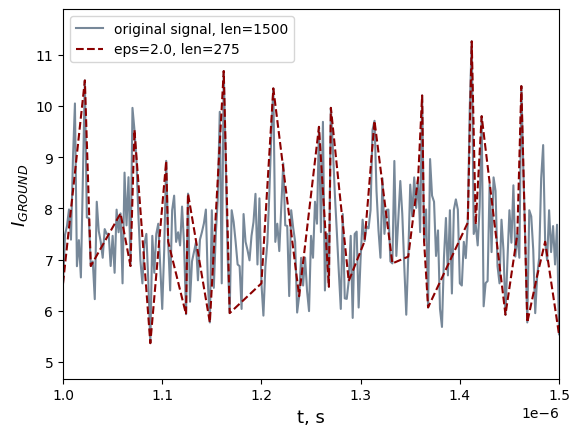

In [8]:
traj_idx = 1
rdp_mask = rdp_classic(G[traj_idx], epsilon=eps, return_mask=True)

plt.plot(t, G[traj_idx][:,0], color='lightslategrey', label=f'original signal, len={len(G[traj_idx])}')
plt.plot(t[rdp_mask], G_reduce_size[traj_idx][:,0], color='darkred', markersize=1, alpha=1, linestyle="--", label=f'eps={eps}, len={len(t[rdp_mask])}')
plt.xlim([1e-6, 1.5e-6])
plt.xlabel('t, s', size=13)
plt.ylabel(r'$I_{GROUND}$', size=13)
plt.legend()
plt.savefig(f'I_ground_eps_{str(eps)}.png', dpi=500)

In [33]:
np.save(OUTPUT_PATH+'G_reduce_size_eps1.npy', G_reduce_size)
np.save(OUTPUT_PATH+'E_reduce_size_eps1.npy', E_reduce_size)

/home/ikarys/miniconda3/envs/trajectory/lib/python3.10/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# distanse calculation

In [18]:
G_reduce_size = np.load(OUTPUT_PATH + "G_reduce_size.npy", allow_pickle=True)

### Py sspd vs C sspd

In [68]:
def sspd_speed(sspd_f = sspd.e_sspd):
    from traj_dist.pydist import sspd
    from time
    import random
    interpreter = 'python' if sspd_f == sspd.e_sspd else 'Cython'
    rand_traj_idxs = [[random.randint(0, len(G)) for _ in range(2)] for _ in range(10)]
    timestamps = []

    for traj_idxs in rand_traj_idxs:
        st = time.time()
        sspd_f(G[traj_idxs[0]], G[traj_idxs[1]])
        et = time.time()
        timestamps.append(et-st)

    print(f'for {interpreter} sspd caluclitons mean time consumptions is {sum(timestamps)/len(timestamps)} sec')

In [69]:
"Python implementation"
sspd_speed(sspd_f = sspd.e_sspd)

"C implementation"
sspd_speed(sspd_f = tdist.sspd)

for python sspd caluclitons mean time consumptions is 11.251836323738098 sec
for Cython sspd caluclitons mean time consumptions is 0.07887985706329345 sec


## Pairwise matrix

In [62]:
"COMPUTING ON A SINGLE CORE"
def pairwise_matrix(traj_list):
    traj_count = len(traj_list)
    M = np.zeros(sum(range(traj_count)))
    im = 0
    for i in range(traj_count):
        traj_list_i = traj_list[i]
        for j in range(i + 1, traj_count):
            traj_list_j = traj_list[j]
            M[im] = tdist.sspd(traj_list_i, traj_list_j)
            im += 1
    return M

In [39]:
"DATA AMOUNT"
traj_list = G[:30]

In [52]:
%%time
"COMPUTING ON  MULTIPLE CORE"
def task(index_i, index_j):
    traj_list_i = traj_list[index_i]
    traj_list_j = traj_list[index_j]
    return tdist.sspd(traj_list_i, traj_list_j)

traj_count = len(traj_list)
M = np.zeros(sum(range(traj_count)))
im = 0
index_list = []
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        index_list.append((i, j))

with Pool() as pool:
    for result in pool.starmap(task, index_list, chunksize=1):
        M[im] = result
        im += 1

CPU times: user 712 ms, sys: 263 ms, total: 975 ms
Wall time: 3.3 s


In [42]:
"CHECK COMPUTING ON A MULTIPLE CORE CORRECTNESS"
all(np.equal(tdist.pdist(traj_list, metric="sspd"), M))

True

In [ ]:
np.save(OUTPUT_PATH+'G_sspd_matrix.npy', M)

## CLUSTERING DISTANCES

In [ ]:
p_dist = np.load(OUTPUT_PATH + "G_sspd_matrix.npy")
Z = fc.linkage(p_dist, method="ward")

In [ ]:
labels =sch.fcluster(Z,25,criterion="maxclust")-1
pickle.dump(labels, open(OUTPUT_PATH+"G_traj_labels.pkl", "wb"))